# Exercise 2.5

<p align="justify">
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the $q_{*}(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_{*}(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.
</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Settings

In [2]:
arms       = 10     # number of "arms" / "bandits"
n_runs     = 1000   # number of runs
n_steps    = 10000  # number of steps

alpha      = 0.1    # step-size parameter (const.)
epsilon    = 0.1    # probability of choosing non-greedily

actions    = np.arange(arms)  # set of actions

### Functions

In [3]:
def q_action_plot(actions, q):
    plt.figure(figsize=(16, 9))
    plt.bar(x=actions+1, height=np.mean(q, axis=0))
    plt.xlabel('Actions (a)')
    plt.ylabel('Q(a)')
    plt.xticks(actions)
    plt.show()
    return


def time_cumreward_plot(time, reward):
    plt.figure(figsize=(16, 9))
    plt.plot(np.arange(time), np.mean(np.cumsum(reward, axis=1), axis=0))
    plt.xlabel('Time')
    plt.ylabel('Cumulative reward')
    plt.show()
    return

### Simulate random walk

In [4]:
def get_walk(mu=0, sigma=1):
    # simulate a random walk
    return np.random.normal(loc=mu, scale=sigma,
                            size=(n_runs, arms, n_steps))
    

def get_rewards(walk=None, init_value=0):
    if walk is None:
        walk = get_walk()
    return np.ones((n_runs, arms, n_steps)) * init_value + np.cumsum(walk, axis=2)

In [5]:
walk = get_walk(mu=0, sigma=0.01)
rewards = get_rewards(walk)

#### Plot of increments (individual steps of a random walk)

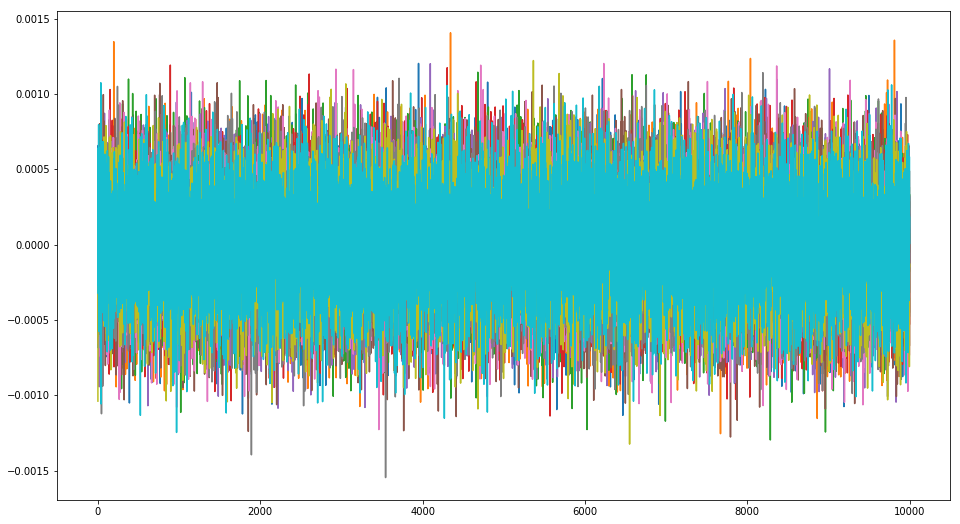

In [6]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(n_steps), np.mean(walk, axis=0).T)
plt.show()

#### Plot of cumulative rewards

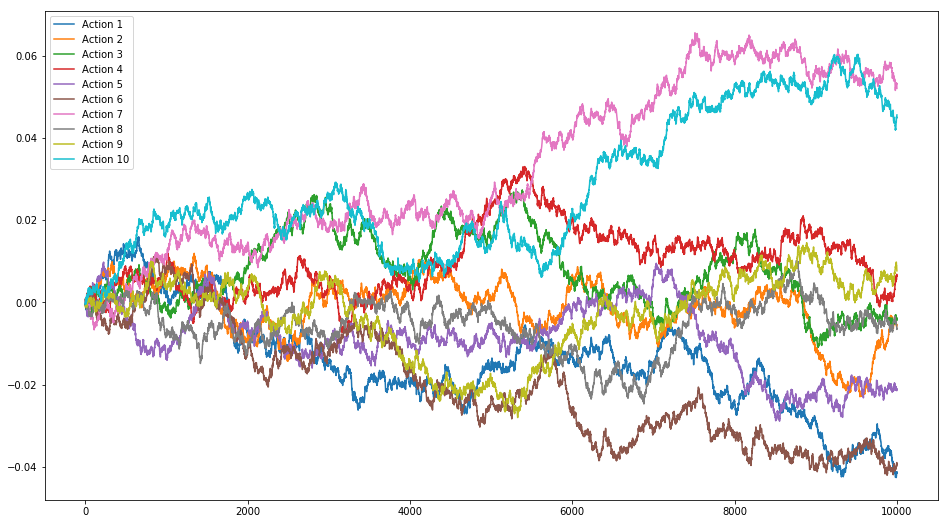

In [7]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(n_steps), np.mean(rewards, axis=0).T)
plt.legend([f"Action {x}" for x in np.arange(10)+1])
plt.show()

### Non-incrementally-computed action-value method | Sample average

$$ Q_{t}(a) = \cfrac{ \text{sum of rewards when $a$ taken prior to $t$} }{ \text{numbr of times $a$ taken prior to $t$} } = \cfrac{ \sum_{i=1}^{t-1} R_{i} \cdot 1_{A_{i}=a} }{ \sum_{i=1}^{t-1} 1_{A_{i}=a} } $$

In [8]:
ni_counter = np.zeros((n_runs, arms))  # number of times a taken prior to t
ni_q = np.zeros((n_runs, arms))  # (sum of rewards) / (number of times)
ni_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

for run in range(n_runs):
    for step in range(n_steps):
        # choose an action
        if np.random.uniform() < epsilon:  # exploration
            action = np.random.choice(actions)
        else:  # exploitation
            max_reward = np.argwhere(ni_q[run] == np.max(ni_q[run]))[:, 0]
            action = np.random.choice(max_reward)  # choose the highest-estimated actions

        # write down the total reward
        ni_reward[run, step] = rewards[run, action, step]

        # update estimations
        ni_q[run, action] *= ni_counter[run, action]
        ni_q[run, action] += rewards[run, action, step]
        ni_counter[run, action] += 1
        ni_q[run, action] /= ni_counter[run, action]

In [9]:
# time_cumreward_plot(n_steps, ni_reward)

In [10]:
# q_action_plot(actions, ni_q)

### Incrementally-computed action-value method | Sample average

$$ Q_{n+1} = \cfrac{R_{1} + R_{2} + \cdots + R_{n}}{n} = Q_{n} + \cfrac{1}{n} \big[ R_{n} - Q_{n} \big]$$

$$ \text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} \big[ \text{Target} - \text{OldEstimate} \big] $$

In [11]:
ii_counter = np.zeros((n_runs, arms))  # number of times a taken prior to t
ii_q = np.zeros((n_runs, arms))  # (sum of rewards) / (number of times)
ii_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

for run in range(n_runs):
    for step in range(n_steps):
        # choose an action
        if np.random.uniform() < epsilon:  # exploration
            action = np.random.choice(actions)
        else:  # exploitation
            max_reward = np.argwhere(ii_q[run] == np.max(ii_q[run]))[:, 0]
            action = np.random.choice(max_reward)  # choose the highest-estimated actions
        
        # write down the total reward
        ii_reward[run, step] = rewards[run, action, step]

        # update estimations
        ii_counter[run, action] += 1
        ii_q[run, action] += (rewards[run, action, step] - ii_q[run, action]) / ii_counter[run, action]

In [12]:
# time_cumreward_plot(n_steps, ii_reward)

In [13]:
# q_action_plot(actions, ii_q)

### Incrementally-computed action-value method | Constant step-size parameter $\alpha$

$$ Q_{n+1} = Q_{n} + \alpha \big[R_{n} - Q_{n} \big] = \ldots = (1 - \alpha)^{n} Q_{1} + \sum_{i=1}^{n} \alpha (1 - \alpha)^{n-i} R_{i}$$

In [14]:
cs_q = np.zeros((n_runs, arms))  # (sum of rewards) * alpha
cs_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

for run in range(n_runs):
    for step in range(n_steps):
        # choose an action
        if np.random.uniform() < epsilon:  # exploration
            action = np.random.choice(actions)
        else:  # exploitation
            max_reward = np.argwhere(cs_q[run] == np.max(cs_q[run]))[:, 0]
            action = np.random.choice(max_reward)  # choose the highest-estimated actions
        
        # write down the total reward
        cs_reward[run, step] = rewards[run, action, step]
    
        # update estimations
        cs_q[run, action] += (rewards[run, action, step] - cs_q[run, action]) * alpha

In [15]:
# time_cumreward_plot(n_steps, cs_reward)

In [16]:
# q_action_plot(actions, cs_q)

### Method comparison

#### Cumulative reward

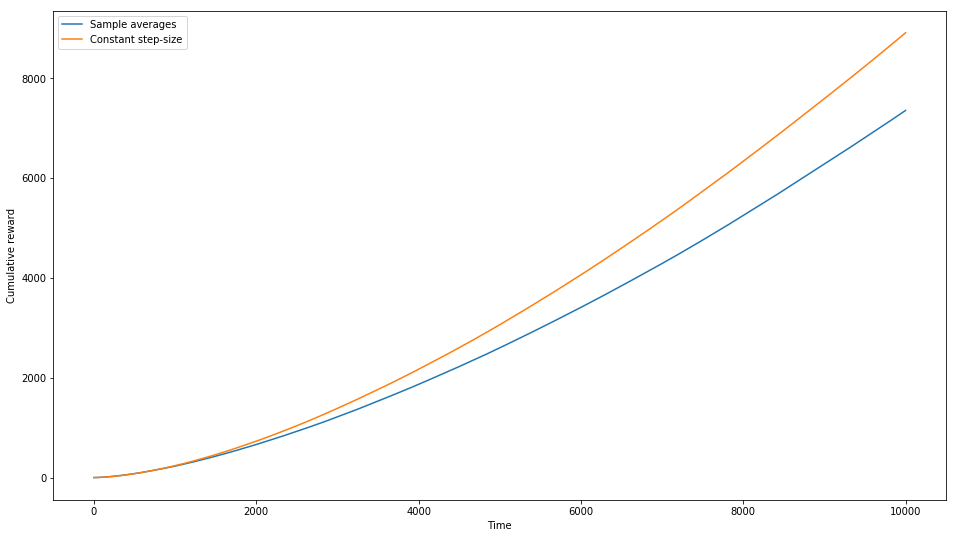

In [20]:
plt.figure(figsize=(16, 9))
# plt.plot(np.arange(n_steps), np.mean(np.cumsum(ni_reward, axis=1), axis=0))
plt.plot(np.arange(n_steps), np.mean(np.cumsum(ii_reward, axis=1), axis=0))
plt.plot(np.arange(n_steps), np.mean(np.cumsum(cs_reward, axis=1), axis=0))
plt.xlabel('Time')
plt.ylabel('Cumulative reward')
plt.legend(['Sample averages', 'Constant step-size'])
plt.show()

#### Average reward

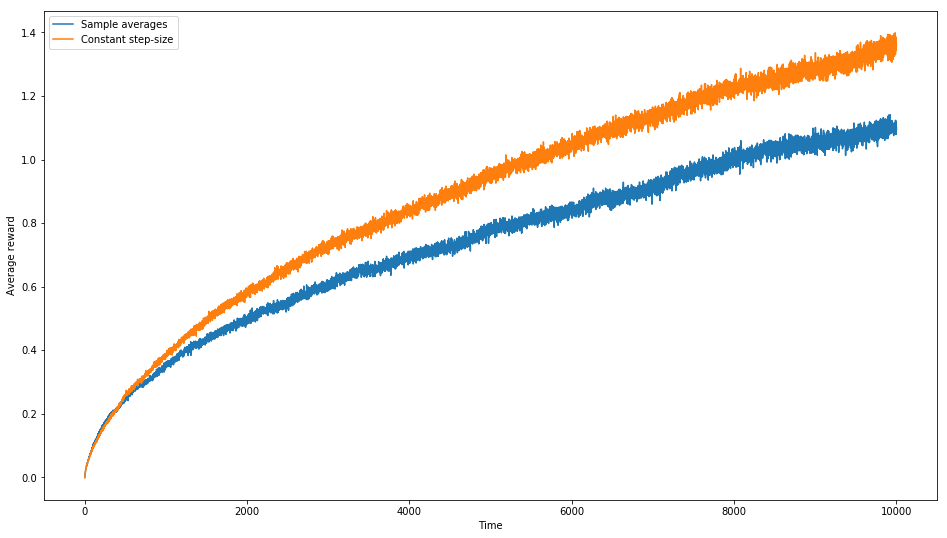

In [21]:
plt.figure(figsize=(16, 9))
# plt.plot(np.arange(n_steps), np.mean(ni_reward, axis=0))
plt.plot(np.arange(n_steps), np.mean(ii_reward, axis=0))
plt.plot(np.arange(n_steps), np.mean(cs_reward, axis=0))
plt.xlabel('Time')
plt.ylabel('Average reward')
plt.legend(['Sample averages', 'Constant step-size'])
plt.show()

#### Optimal action

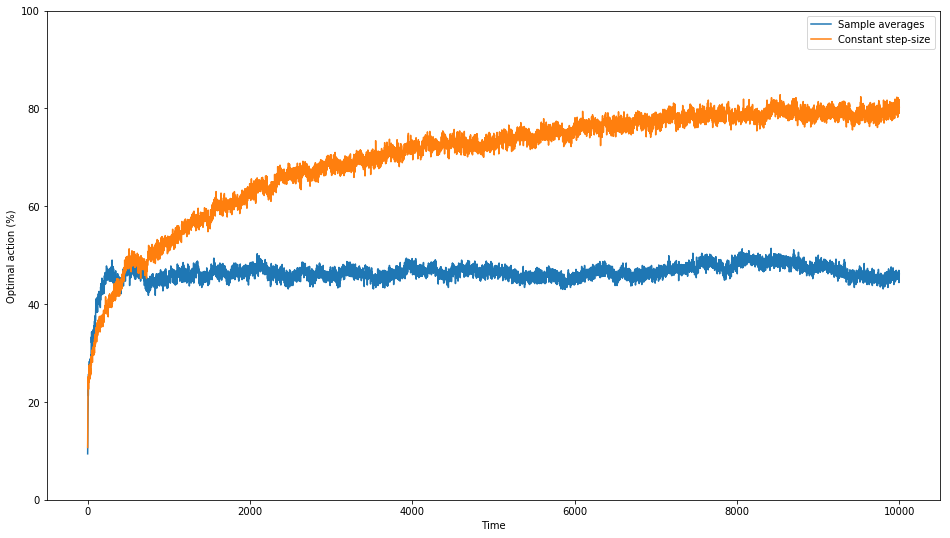

In [22]:
plt.figure(figsize=(16, 9))
# plt.plot(np.arange(n_steps), np.sum(ni_reward == np.max(rewards, axis=1), axis=0) / n_runs * 100)
plt.plot(np.arange(n_steps), np.sum(ii_reward == np.max(rewards, axis=1), axis=0) / n_runs * 100)
plt.plot(np.arange(n_steps), np.sum(cs_reward == np.max(rewards, axis=1), axis=0) / n_runs * 100)
plt.xlabel('Time')
plt.ylabel('Optimal action (%)')
plt.ylim(0, 100)
plt.legend(['Sample averages', 'Constant step-size'])
plt.show()